# Q1.Data Processing
1. 결측치 대체 :   
   머신러닝/딥러닝 기반의 결측치 대체 모델을 활용하여 결측치를 효과적으로 보간한 후, 분류 모델을 개발.
   #
2. 클래스 불균형 문제 해결 :    
당뇨(Target_DM) 및 고혈압(Target_HT) 유병에 대한 각 분류 모델을 만들 때 클래스 불균형 문제를 고려하여 모델 성능을 개선

| 전략             | 설명                                                         |
|------------------|--------------------------------------------------------------|
| **SMOTE**        | 소수 클래스 데이터를 합성하여 늘림                          |
| **언더샘플링**   | 다수 클래스 데이터를 줄임                                    |
| **Class weight** | `class_weight='balanced'` 같은 옵션으로 자동 가중치 부여    |
| **앙상블 기법**  | 다수의 모델을 조합하여 클래스 불균형을 완화                 |


## 데이터 확인
- 건강검진 및 생체 정보 데이터셋   
- 31 column   
- 시계열 데이터X, 변수별 연관성은 있을 것 같음.

In [1]:
# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01.csv")

# print(data.head())  # 데이터 일부 출력
# print(data.info())  # 데이터 정보 출력
# print(data.describe())  # 데이터 통계 정보 출력

In [2]:
# 클래스 불균형 확인
print(data['Target_DM'].value_counts())
print(data['Target_HT'].value_counts())

Target_DM
0.0    19094
1.0      881
Name: count, dtype: int64
Target_HT
0.0    17888
1.0     2087
Name: count, dtype: int64


---
## **Flow**   
> step01 : 변수별 결측 수치(ratio) 확인   
> - 완전히 결측된 colums data 3col 발견 --> 제거   
> - target colums : y에 해당하는 컬럼. --> 해당 칼럼에도 24개 결측치 있음. 우선 해당 작업에서는 drop
   #   
> setp02 : Autoencoder로 결측치 대체   
> - hyperparameters 구하기
> - Autoencoder 모델 학습
> - 데이터 재정의(step04에서 사용)  
   #
> setp03 : 분류모델 적용(**데이터 불균형 고려**)   
   #
> setp04 : Baseline으로 MICE, KNN 등 비교 -> 내가 사용한 모델이 진짜 괜찮은지 검증
> - 원본 데이터의 결측치 → MICE로 대체 → 분류모델 적용 → 성능 기록
> - 원본 데이터의 결측치 → KNN으로 대체 → 분류모델 적용 → 성능 기록
> - 원본 데이터의 결측치 → Autoencoder로 대체 → 분류모델 적용 → 성능 기록
>> (Autoencoder)결과가 좋아야할텐데..

---
## step01   

In [3]:
# 완전한 결측치 제거
drop_cols = ['HE_Ucot', 'HE_FVC', 'HE_Frtn']
df = data.drop(columns=drop_cols)

In [4]:
missing_count = df.isnull().sum()     # 칼럼별 결측치 개수
missing_ratio = df.isnull().mean() * 100

# 보기 좋게 하나의 데이터프레임으로 정리
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio (%)': missing_ratio
})

# 결측치가 있는 변수만 필터링 
missing_df = missing_df[missing_df['Missing Count'] > 0]

# 결측치 많은 순으로 정렬
missing_df = missing_df.sort_values(by='Missing Count', ascending=False)

print(missing_df)

           Missing Count  Missing Ratio (%)
HE_Bplt            11882          59.412971
HE_USG              6941          34.706735
HE_Uph              6941          34.706735
HE_WBC              6759          33.796690
HE_HbA1c            6189          30.946547
HE_LDL              3122          15.610781
HE_TG                333           1.665083
HE_glu               330           1.650083
HE_ALT               262           1.310066
HE_AST               227           1.135057
HE_HB                219           1.095055
HE_HCT               215           1.075054
HE_RBC               213           1.065053
HE_BUN               213           1.065053
HE_CHOL              212           1.060053
HE_HDL               210           1.050053
HE_CREA              187           0.935047
HE_PLS               169           0.845042
Target_DM             24           0.120006
Target_HT             24           0.120006
HE_WC                  4           0.020001


In [5]:
# 타겟 변수 분리
target_cols = ['Target_DM', 'Target_HT']

# 타겟값이 NULL 24개는 제거
df = df.dropna(subset=['Target_DM','Target_HT'])                    # 24개 NaN데이터들은 삭제 
features = df.drop(columns=target_cols)
targets = df[target_cols]


# features로만 결측치 대체해보기
features

,SEX,AGE,HE_WT,HE_HT,HE_WC,HE_BMI,HE_SBP,HE_DBP,HE_PLS,HE_Uph,...,HE_AST,HE_ALT,HE_CHOL,HE_TG,HE_HDL,HE_LDL,HE_glu,HE_HbA1c,HE_BUN,HE_CREA
0,2,50,64.24,157.8,96.8,25.798326,152.0,86.0,17.0,6.0,...,27.0,27.0,229.0,113.0,47.0,159.4,261.0,10.3,14.0,0.8
1,1,32,78.24,169.5,92.2,27.232621,111.0,71.0,20.0,5.0,...,30.0,27.0,274.0,173.0,43.0,196.4,69.0,4.0,19.0,1.1
2,2,31,53.60,150.7,69.3,23.601428,118.0,68.0,21.0,5.0,...,15.0,15.0,163.0,82.0,64.0,82.6,95.0,5.0,10.0,0.8
3,2,32,59.56,154.3,78.8,25.016286,116.0,83.0,18.0,5.0,...,20.0,12.0,145.0,64.0,70.0,62.2,94.0,4.5,11.0,0.8
4,2,67,57.70,146.2,89.2,26.994859,155.0,95.0,17.0,6.5,...,28.0,21.0,171.0,85.0,51.0,103.0,122.0,5.5,15.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,1,34,53.00,161.5,72.9,20.320333,121.0,81.0,17.0,6.5,...,24.0,18.0,160.0,98.0,48.0,92.4,86.0,NaN,9.8,1.0
19995,2,29,61.10,163.5,78.5,22.856288,103.0,72.0,16.0,5.0,...,16.0,12.0,151.0,213.0,29.0,79.4,89.0,NaN,8.7,0.9
19996,2,61,65.50,151.0,90.5,28.726810,140.0,81.0,15.0,5.5,...,16.0,13.0,245.0,593.0,28.0,NaN,141.0,7.8,18.6,0.8
19997,1,57,72.60,165.0,90.5,26.666667,119.0,80.0,20.0,5.0,...,21.0,25.0,188.0,56.0,52.0,124.8,107.0,NaN,25.9,1.0


In [6]:
# 결측 마스크 저장 : features에서 결측치가 있는 위치를 mask라는 변수에 바이너리값으로 저장. --> mask값이 True인 값을 딥러닝을 통해 예측하여 구현할 것
mask = features.isnull()

# 임시 결측치 대체 (컬럼 평균으로)
features_filled = features.fillna(features.mean())

# 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filled)

---
## step02 : 딥러닝 기반 모델로 결측치 대체하기   
   #
Autoencoder 기반 Imputer (딥러닝 방식)   
- 원리: 입력 데이터를 압축하고 복원하는 구조를 이용해 결측치를 예측    
- 장점: 복잡한 비선형 관계를 학습 가능   
   #

search_hyperparameters.py
- 최적의 하이퍼파라미터 찾기   
- 1시간 30분정도, 90개 실험
> batch 64   
> epochs = 50   
> lr = 0.0005   
> optimizer = Adam   



In [7]:
from impute_model import Autoencoder
from utils import *
from sklearn.preprocessing import StandardScaler

# # step01 : 데이터 전처리 파트 한번에 처리
# # features : 필요없는 칼럼 삭제한 df
# # features_filled : # 임시 결측치 대체함
# # mask : 결측치 True/False 값
# features,features_filled, mask = data_processing()

# # 스케일링
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features_filled)

# 텐서형태로 변환
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
rows=X_tensor.shape[1]

In [8]:
# step02 : 모델 실험.

###### setting : hyperparameters 고정, 모델은 Autoencoder
model = Autoencoder(input_dim=rows)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)      # Adam, 0.001, 40
epochs = 50
batch_size = 64

train_X, test_X = dataset_split(features_scaled)
train_loader, test_loader = loader_dataset(train_X,test_X,batch_size)

# training
model.model_train_fixed_hyperparameter(train_loader,optimizer,epochs)

# 모델 저장
torch.save(model.state_dict(), "autoencoder_model.pth")

####################### Train! #######################
Epoch 1/50 - Loss: 163.8352
Epoch 11/50 - Loss: 5.7978
Epoch 21/50 - Loss: 1.7906
Epoch 31/50 - Loss: 0.6288
Epoch 41/50 - Loss: 0.4292
> Final ::: Epoch 50/50 - Loss: 0.4516

> 총 실행 시간: 40.29초


In [9]:
# step03 : model로 결측값 예측 : predicted_values

# # # 저장했던 모델 부르기
# model = Autoencoder(input_dim=rows)
# model.load_state_dict(torch.load("autoencoder_model.pth"))

model.eval()  # 평가 모드로 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # gpu 

with torch.no_grad():
    X_tensor = X_tensor.to(device)  # 잊지 말고 model과 같은 디바이스로
    predicted_values = model(X_tensor).detach().cpu().numpy()
    
assert predicted_values.shape == features_scaled.shape

In [10]:
# step04-2 : 복원하기
X_final = replace_missing_values(features_scaled,mask,predicted_values,scaler)

# 역스케일링
X_final = scaler.inverse_transform(X_final)
df_imputed = pd.DataFrame(X_final, columns=features.columns)
df_result = pd.concat([df_imputed, targets.reset_index(drop=True)], axis=1)

In [11]:
## 확인하기
print('# 결측값 : ',data['HE_Bplt'][19972])
print('# 임의로 평균값 대체 : ',features_filled['HE_Bplt'][19972])
print('# autoencoder 대체값 : ',df_result['HE_Bplt'][19972])

# 결측값 :  nan
# 임의로 평균값 대체 :  23.92620426265862
# autoencoder 대체값 :  23.832523065333923


----

In [12]:
# 클래스 불균형 확인
print(df_result['Target_DM'].value_counts())
print(df_result['Target_HT'].value_counts())

Target_DM
0.0    19094
1.0      881
Name: count, dtype: int64
Target_HT
0.0    17888
1.0     2087
Name: count, dtype: int64


---

# 샘플링..

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # SMOTE를 위한 패키지
from imblearn.under_sampling import RandomUnderSampler  # 언더샘플링 옵션
from imblearn.pipeline import Pipeline  # 여러 스텝을 연결

X = df_result
# 1. 데이터 준비
x_DM = df_result.drop(columns=["Target_DM"])  # 당뇨 질병 유병 여부
y_DM = df_result["Target_DM"].astype(int)  # 타겟

x_HT = df_result.drop(columns=["Target_HT"])  # 고혈압 질병 유병 여부
y_HT = df_result["Target_HT"].astype(int)  # 타겟

# 2. 학습/테스트 데이터 분리
x_DM_train, x_DM_test, y_DM_train, y_DM_test = train_test_split(x_DM, y_DM, test_size=0.2, random_state=42)
x_HT_train, x_HT_test, y_HT_train, y_HT_test = train_test_split(x_HT, y_HT, test_size=0.2, random_state=42)

# 3. 스케일링
scaler_DM = StandardScaler()
x_DM_train_scaled = scaler_DM.fit_transform(x_DM_train)
x_DM_test_scaled = scaler_DM.transform(x_DM_test)

scaler_HT = StandardScaler()
x_HT_train_scaled = scaler_HT.fit_transform(x_HT_train)
x_HT_test_scaled = scaler_HT.transform(x_HT_test)

# 4. SMOTE or 언더샘플링 적용
#    방법 1: 오버샘플링만
# sampler = SMOTE(random_state=42)

#    방법 2: 언더샘플링만
# sampler = RandomUnderSampler(random_state=42)

#    방법 3: 오버샘플링 + 언더샘플링 혼합 (선택)
# sampler = Pipeline(steps=[
#     ('over', SMOTE(sampling_strategy=0.8, random_state=42)),
#     ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42))
# ])

# x_DM_resampled, y_DM_resampled = sampler.fit_resample(x_DM_train_scaled, y_DM_train)
# x_DM_resampled, y_DM_resampled = sampler.fit_resample(x_DM_train_scaled, y_DM_train)

## step03 : 의사결정나무 트리를 이용하여 분류 모델

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, log_loss, brier_score_loss
)
import seaborn as sns
import matplotlib.pyplot as plt

# 의사결정나무 모델 학습 : 클래스 불균형
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(x_DM_train_scaled, y_DM_train)

# 예측 및 평가
y_pred = dt_model.predict(x_DM_test_scaled)
y_proba = dt_model.predict(x_DM_test_scaled)

# 성능 지표 계산
metrics = {
    "Accuracy": accuracy_score(y_DM_test, y_pred),
    "Precision": precision_score(y_DM_test, y_pred),
    "Recall": recall_score(y_DM_test, y_pred),
    "F1 Score": f1_score(y_DM_test, y_pred),
    "ROC AUC": roc_auc_score(y_DM_test, y_proba),
    "Log Loss": log_loss(y_DM_test, y_proba),
    "Brier Score": brier_score_loss(y_DM_test, y_proba)
}

# 보기 좋게 정리
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
print("▶️ 다양한 분류 성능 지표")
display(metrics_df.round(4))

# 추가로 Classification Report 전체 출력
print("\nClassification Report:\n", classification_report(y_DM_test, y_pred))

▶️ 다양한 분류 성능 지표


,Score
Accuracy,0.9517
Precision,0.4675
Recall,0.3934
F1 Score,0.4273
ROC AUC,0.6860
Log Loss,1.7413
Brier Score,0.0483



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3812
           1       0.47      0.39      0.43       183

    accuracy                           0.95      3995
   macro avg       0.72      0.69      0.70      3995
weighted avg       0.95      0.95      0.95      3995



In [15]:
#하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 의사결정나무 모델
dt = DecisionTreeClassifier(class_weight='balanced',random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',  # 다른 점수도 가능: accuracy, roc_auc 등
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 학습
grid_search.fit(x_DM_train_scaled, y_DM_train)

# 결과 출력
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best F1 Score: 0.4314


In [16]:
# 최적 모델로 재평가
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(x_DM_test_scaled)
y_proba_best = best_dt.predict_proba(x_DM_test_scaled)[:, 1]


# 성능 재정리
best_metrics = {
    "Accuracy": accuracy_score(y_DM_test, y_pred_best),
    "Precision": precision_score(y_DM_test, y_pred_best),
    "Recall": recall_score(y_DM_test, y_pred_best),
    "F1 Score": f1_score(y_DM_test, y_pred_best),
    "ROC AUC": roc_auc_score(y_DM_test, y_proba_best),
    "Log Loss": log_loss(y_DM_test, y_proba_best),
    "Brier Score": brier_score_loss(y_DM_test, y_proba_best)
}

print("\n▶️ 최적 모델 성능")
display(pd.DataFrame.from_dict(best_metrics, orient='index', columns=['Score']).round(4))


▶️ 최적 모델 성능


,Score
Accuracy,0.9294
Precision,0.3173
Recall,0.4699
F1 Score,0.3789
ROC AUC,0.7138
Log Loss,1.4529
Brier Score,0.0661


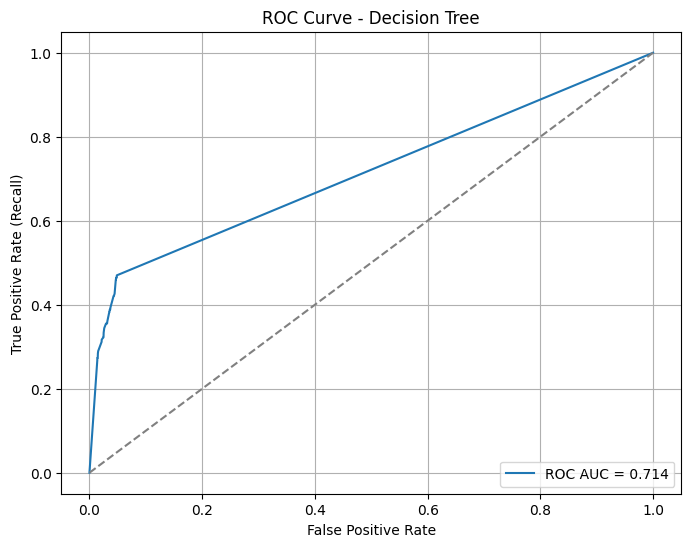

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률
y_proba_best = best_dt.predict_proba(x_DM_test_scaled)[:, 1]

#ROC Curve plot
# ROC 커브 계산
fpr, tpr, thresholds = roc_curve(y_DM_test, y_proba_best)
auc_score = roc_auc_score(y_DM_test, y_proba_best)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

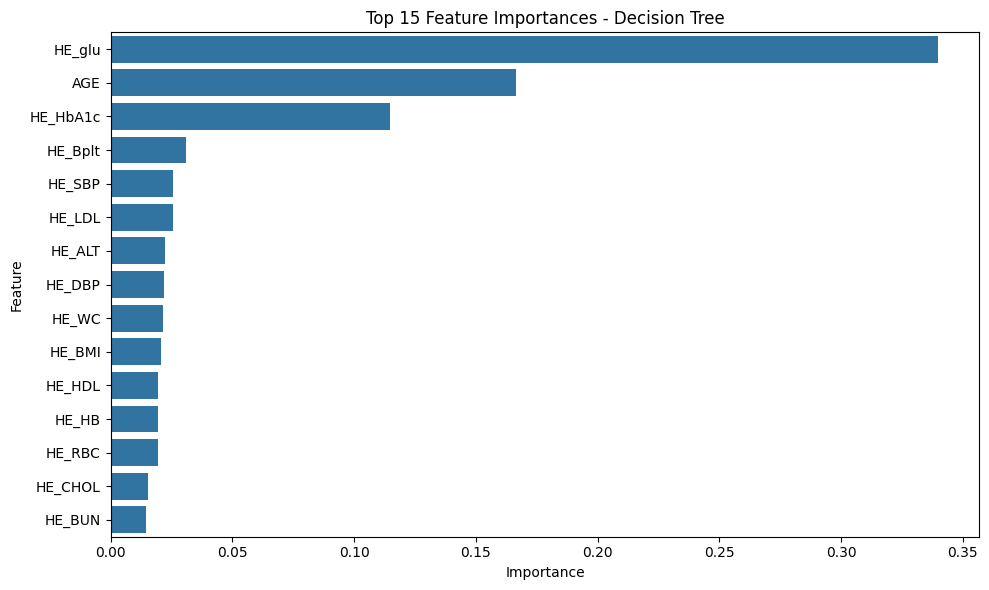

In [18]:
# 변수 중요도 시각화
# 변수 중요도 정리
importances = best_dt.feature_importances_
feature_names = x_DM.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 상위 15개 변수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
plt.title("Top 15 Feature Importances - Decision Tree")
plt.tight_layout()
plt.show()

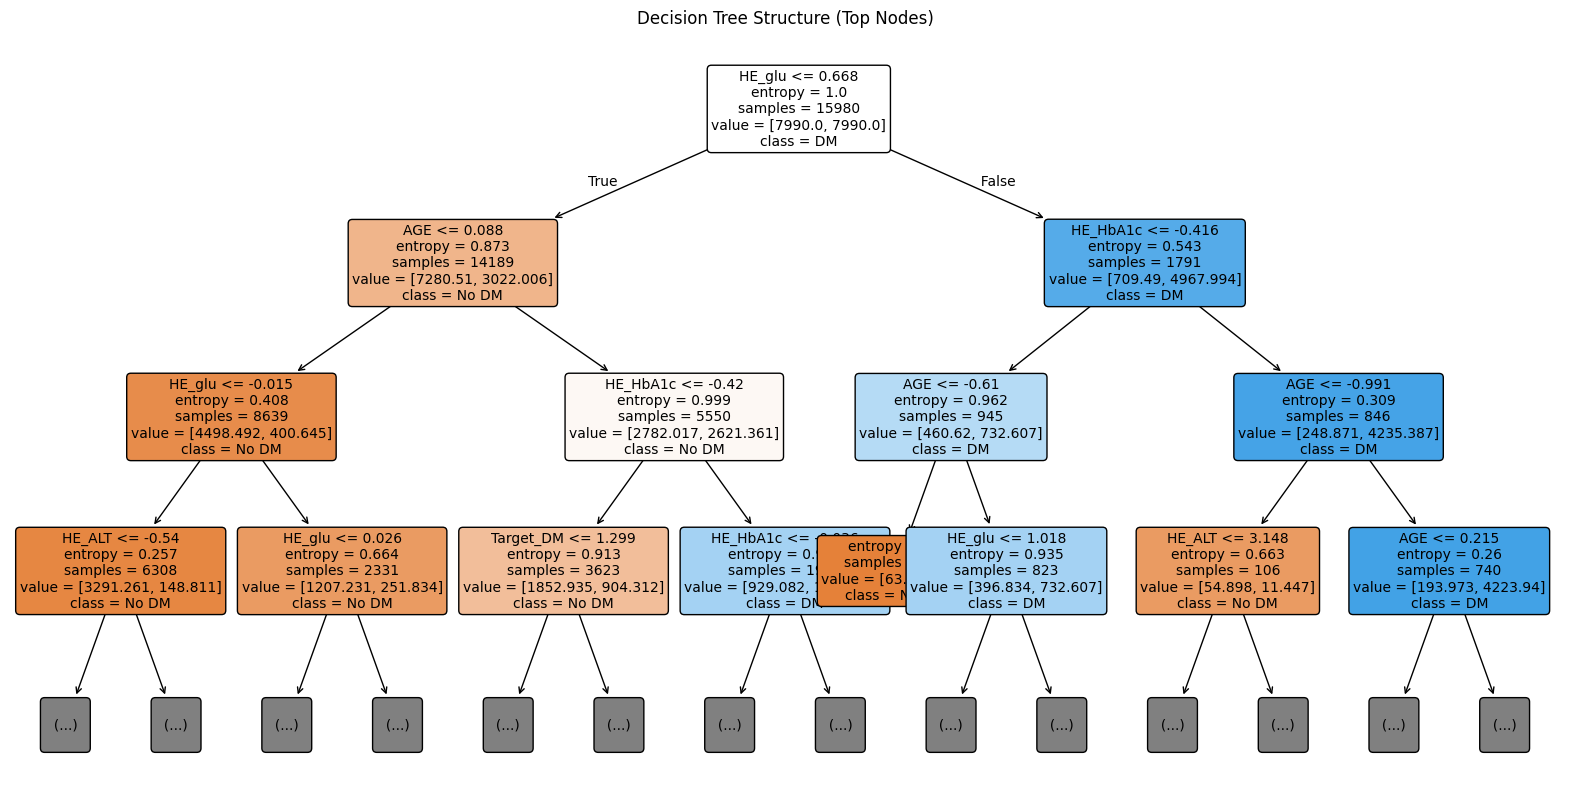

In [19]:
from sklearn.tree import plot_tree
# 시각화
plt.figure(figsize=(20, 10))  # 크기는 필요에 따라 조절 가능
plot_tree(
    best_dt,
    feature_names=X.columns,
    class_names=["No DM", "DM"],
    filled=True,
    rounded=True,
    max_depth=3,  # 트리 깊이 제한 없이 전체를 보고 싶다면 이 줄 제거 또는 None으로 설정
    fontsize=10
)
plt.title("Decision Tree Structure (Top Nodes)")
plt.show()

---
## Step03 : 앙상블 모델 이용하여 분류 모델 성능 비교   

In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

neg, pos = y_DM_train.value_counts()
scale_pos_weight = neg / pos

# 모델 정의
models = {
    "mymodle_Decision Tree": best_dt,
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,scale_pos_weight=scale_pos_weight),
    "LightGBM": LGBMClassifier(random_state=42,is_unbalance=True)
}

# 성능 저장용 딕셔너리
results = {}


for name, model in models.items():
    model.fit(x_DM_train_scaled, y_DM_train)
    y_pred = model.predict(x_DM_test_scaled)
    y_proba = model.predict_proba(x_DM_test_scaled)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_DM_test, y_pred),
        "F1 Score": f1_score(y_DM_test, y_pred),
        "ROC AUC": roc_auc_score(y_DM_test, y_proba)
    }

# 결과 출력
results_df = pd.DataFrame(results).T.round(4)
print("트리 기반 모델 성능 비교")
display(results_df)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:21:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 698, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5310
[LightGBM] [Info] Number of data points in the train set: 15980, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043680 -> initscore=-3.086212
[LightGBM] [Info] Start training from score -3.086212
트리 기반 모델 성능 비교


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
mymodle_Decision Tree,0.9294,0.3789,0.7138
Decision Tree,0.9517,0.4273,0.6860
Random Forest,0.9559,0.2727,0.9274
XGBoost,0.9577,0.5239,0.9225
LightGBM,0.9504,0.5520,0.9250


---

# 결론(작성중)   

클래스 불균형 한거랑 안한거랑 비교하기..